In [ ]:
# default_exp models.dls

# DataLoaders

> Deep Learning DataLoaders with Fastai/Pytorch.

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.preprocessing import *

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    from fastai.vision.all import *
    from fastai.data.all import *
    import fastai
from fastcore.foundation import *

In [ ]:
# hide
only_imgs = ["0a1cade03.jpg", "bca4ae758.jpg", "988cf521f.jpg", "b6a257b28.jpg",
             "b2ad335bf.jpg", "72aaba8ad.jpg", "f383950e8.jpg"]
train = train[train["ImageId"].isin(only_imgs)].copy()
train_all = train_all[train_all["ImageId"].isin(only_imgs)].copy()
train_multi = train_multi[train_multi["ImageId"].isin(only_imgs)].copy()
train_pivot = train_pivot.loc[train_pivot.index.isin(only_imgs)].copy()

## From fast.ai

In this module you can have functions for a classification and a segmentation problem. 

To get a `DataLoaders` object for training FastAI models, the `get_dls` functions will: 
- load the training images
- load the corrisponding labels (saved in `labels_dir` by the `preprocessing` module with the `create_mask` function)
- pair the images with labels with a `Dataset`
- split the dataset into training and validation and pair them with a `Datasets` object.
- for each dataset, create a `DataLoader` with a batch size and pair them with a `DataLoaders` object.

### Classification

The `get_classification_dls` function elaborates the training and validation examples (with hard negatives) from the `train_multi` DataFrame built in the `core` module.

In [ ]:
# export
def get_classification_dls(bs, with_tfms: bool = True, size=None):
    """
    Dataloaders from train DataFrame
    """
    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_tfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=0.,
            flip_vert=True,
            max_rotate=5.,
            max_lighting=0.1)

    dblock = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock()),
        get_x=ColReader(0, pref=train_path),
        get_y=ColReader(1, label_delim=' '),
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_multi, bs=bs)

In [ ]:
bs = 4
dls = get_classification_dls(bs)

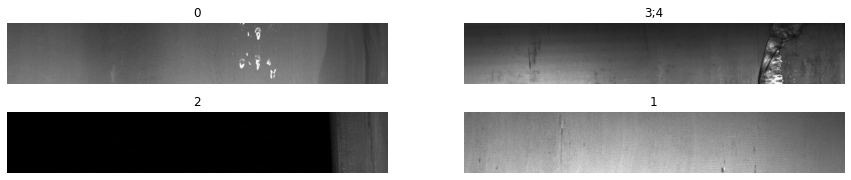

In [ ]:
dls.train.show_batch(figsize=(15, 3))

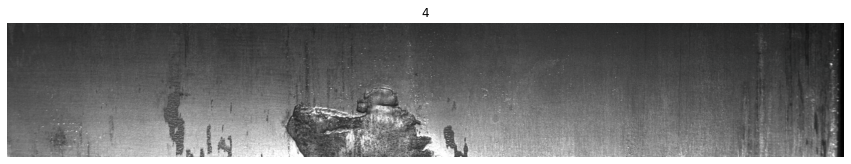

In [ ]:
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
x, y = dls.train.one_batch()
x.shape, y.shape

((4, 3, 256, 1600), (4, 5))

### Segmentation

The `get_segmentation_dls` will load from the folder all the images while the `get_segmentation_dls_from_df` loads the images from a custom `DataFrame` to train on a different subsample.

In [ ]:
# export
classes = [0, 1, 2, 3, 4]

def get_segmentation_dls(bs, size, with_btfms=True):
    """Dataloaders from `train_path` folder"""

    b_tfms = [Normalize.from_stats(*imagenet_stats)]

    if with_btfms:
        b_tfms += aug_transforms(
            size=size if size else (256, 1600),
            max_warp=0.,
            flip_vert=True,
            max_rotate=5.,
            max_lighting=0.1)

    def get_labels_from_img(p):
        return labels_dir/f'{p.stem}_P.png'

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_items=get_image_files,
        get_y=get_labels_from_img,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        batch_tfms=b_tfms)

    return dblock.dataloaders(train_path, bs=bs)

In [ ]:
# missing
bs = 4
szs = (128, 800)
dls = get_segmentation_dls(bs, szs)

In [ ]:
# export
def get_segmentation_dls_from_df(train_df, bs, size):
    """Dataloaders from `train` DataFrame"""
    def get_x(df):
        img_name = df["ImageId"]
        return train_path / str(img_name)

    def get_y(df):
        img_name = df["ImageId"].split(".")[0] + "_P.png"
        return labels_dir / img_name

    dblock = DataBlock(
        blocks=(ImageBlock, MaskBlock(codes=classes)),
        get_x=get_x,
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        batch_tfms=aug_transforms(size=size))

    return dblock.dataloaders(train_df, bs=bs)

In [ ]:
# missing
bs = 4
szs = (128, 800)
dls = get_segmentation_dls_from_df(train_multi, bs, szs)

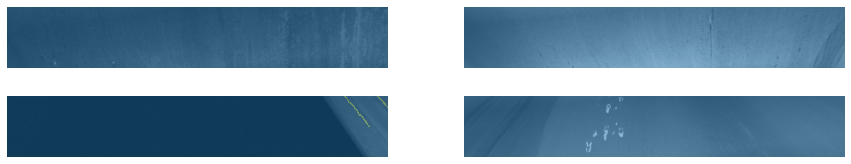

In [ ]:
dls.train.show_batch(figsize=(15, 3))

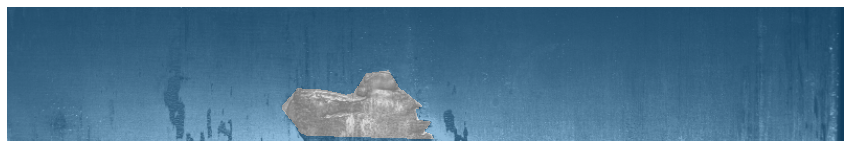

In [ ]:
dls.valid.show_batch(figsize=(15, 3))

In [ ]:
x, y = dls.train.one_batch()
x.shape, y.shape

((4, 3, 128, 800), (4, 128, 800))

The masks have a label for every pixel wich corresponds to a specific class inside the `classes` list.

In [ ]:
[torch.unique(y[i]) for i in range(bs)]

[TensorMask([0, 3, 4]),
 TensorMask([0, 2]),
 TensorMask([0, 3]),
 TensorMask([0])]

## From Kaggle kernel

In [ ]:
# export
import os
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, sampler
from albumentations import (
    HorizontalFlip, ShiftScaleRotate, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensor
import albumentations as alb

In the Kaggle kernel are applied only few preprocessing transforms. In the trainig phase only the horizontal flip.

In [ ]:
# export
def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5),  # only horizontal flip for now
            ]
        )
    list_transforms.extend(
        [
            alb.Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [ ]:
get_tsfms = get_transforms('train', *imagenet_stats)
get_tsfms

Compose([
  HorizontalFlip(always_apply=False, p=0.5),
  Normalize(always_apply=False, p=1, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensor(always_apply=True, p=1.0, num_classes=1, sigmoid=True, normalize=None),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [ ]:
# export
class SteelDataset(Dataset):

    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = train_path / image_id
        #img = cv2.imread(str(image_path))
        img = np.array(Image.open(image_path))
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']         # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1)  # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)

In [ ]:
steel_ds = SteelDataset(train_pivot, path, *imagenet_stats, 'train')
test_eq(len(steel_ds), 6)

In [ ]:
img_tensor, img_mask = steel_ds[0]
img_tensor.shape, img_mask.shape

(torch.Size([3, 256, 1600]), torch.Size([4, 256, 1600]))

In [ ]:
# export
class TestDataset(Dataset):
    '''Dataset for test prediction'''

    def __init__(self, root, df, mean, std):
        self.root = root
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = alb.Compose(
            [
                alb.Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        fpath = self.root / fname
        image = np.array(Image.open(fpath))
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [ ]:
test_dataset = TestDataset(train_path, train_multi, *imagenet_stats)
test_eq(len(test_dataset), 7)

In [ ]:
img_name, img_tensor = test_dataset[0]
print(img_name)
img_tensor.shape

0002cc93b.jpg


torch.Size([3, 256, 1600])

In [ ]:
# export
def get_kaggle_train_dls(
        phase,
        data_folder=path,
        mean=None,
        std=None,
        batch_size=8,
        num_workers=4,
    ):
    '''Returns dataloader for the model training.'''
    df = train_pivot
    if not mean and not std:
        mean, std = imagenet_stats
        
    train_df, val_df = train_test_split(
        df, test_size=0.2, stratify=df["n"], random_state=69)
    
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )

    return dataloader

In [ ]:
# missing
steel_dls = get_kaggle_train_dls(phase='train')
test_eq(len(steel_dls), 667)

In [ ]:
# export
def get_kaggle_test_dls(
        sample_submission_path,         
        best_threshold=0.5, num_workers=2, 
        batch_size=4, min_size=3500, 
        mean=None, std=None
    ):
    """Returns dataloader for testing."""
    if not mean and not std:
        mean, std = imagenet_stats
    df = pd.read_csv(sample_submission_path)
    testset = DataLoader(
        TestDataset(test_path, df, mean, std),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return testset

In [ ]:
# missing
test_dls = get_kaggle_test_dls(path / 'sample_submission.csv')
test_eq(len(test_dls), 1377)

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_models.dls.ipynb.
Converted 04_model.metrics.ipynb.
Converted 05_models.unet.ipynb.
Converted 06_models.model.ipynb.
Converted index.ipynb.
